In [1]:
from collections import defaultdict

import numpy as np

import torch
import torch as tc
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

One Hot Encoding

0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
4 -> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
6 -> [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
7 -> [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
8 -> [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [2]:
def generate_sequence(pattern_length_min = 1, pattern_length_max = 10, palindrome=False):
    pattern_length = np.random.randint(pattern_length_min, pattern_length_max + 1)
    pattern = np.random.randint(0, 10, pattern_length)
    match = np.random.rand() >= 0.5

    sequence = np.zeros(2 * pattern_length, dtype=np.int64)
    sequence[:pattern_length] = pattern
    if match:
        sequence[pattern_length:] = pattern[::-1] if palindrome else pattern
    else:
        second_half = np.random.randint(0, 10, pattern_length)
        while np.array_equal(second_half, pattern):
            second_half = np.random.randint(0, 10, pattern_length)
        sequence[pattern_length:] = second_half

    x = np.zeros((len(sequence), 10), dtype=np.float32)
    y = np.array([1.0 if match else 0], dtype=np.int16)

    for i, ch in enumerate(sequence):
        x[i, ch] = 1

    return torch.tensor(x), torch.tensor(y), sequence

In [100]:
pattern_length = np.random.randint(1, 11) # pattern_length_min 부터 pattern_length_max 중 에서 random한 int값 반환
print(pattern_length)
pattern = np.random.randint(0, 10, pattern_length) #low, high, size
print(pattern)
match = np.random.rand()
sequence = np.zeros(2*pattern_length, dtype=np.int64)
print(sequence)
sequence[:pattern_length] = pattern
print(sequence)
sequence[pattern_length:]



2
[9 7]
[0 0 0 0]
[9 7 0 0]


array([0, 0], dtype=int64)

ex)
x, y, seq = generate_sequence()

=> x :  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

=> y :  tensor([1], dtype=torch.int16)     # 1 if the front and back part of the original sequence match,
                                             0 if not match

=> seq: [9 1 4 9 1 4]

In [3]:
for i in range(3):
    x, y, seq = generate_sequence()
    print(f"original sequence : {seq}")
    print(f"shape of x : {x.shape}")
    print(f"x : {x}")
    print(f"y : {y}")  # original sequence의 압부분과 뒷부분과 일치하면 1, 일치하지 않으면 0 출력
    

original sequence : [4 1 9 1]
shape of x : torch.Size([4, 10])
x : tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
y : tensor([0], dtype=torch.int16)
original sequence : [9 5 3 2 7 9 5 3 2 7]
shape of x : torch.Size([10, 10])
x : tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
y : tensor([1], dtype=torch.int16)
original sequence : [2 1 4 2 3 9 4 8 9 9 3 5 8 0]
shape of x : torch.Size([14, 10

In [4]:
for i in range(100):
    x, y, seq = generate_sequence()
    assert len(x) == len(seq)
    assert (seq[:len(seq)//2] == seq[-len(seq)//2:]).all() == bool(y.item())
    assert (x[:len(x)//2] == x[-len(x)//2:]).all().item() == bool(y.item())

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class RNN(nn.Module):
    def __init__(self, input, recurrent, output):
        super(RNN, self).__init__()

        self.fc_x2h = nn.Linear(input, recurrent)
        self.fc_h2h = nn.Linear(recurrent, recurrent)
        self.fc_h2y = nn.Linear(recurrent, output)
        self.relu = nn.ReLU()


    def forward(self, x, h=None):
        if h is None:
             h = torch.zeros(1, self.fc_h2h.out_features, device=x.device)   

        h_list = []

        for x_t in x:
            h = self.relu(self.fc_x2h(x_t.unsqueeze(0)) + self.fc_h2h(h))     
            h_list.append(h)

        all_h = torch.cat(h_list, dim=0)

        all_y = self.fc_h2y(all_h)

        return all_y, all_h

In [6]:
model = RNN(input=10, recurrent=50, output=2)

optimizer = optim.Adam(model.parameters())

In [7]:
def accuracy(predictions, truth):
    predicted_labels = torch.argmax(predictions, axis = 1)
    correct = (predicted_labels == truth).float()

    accuracy = correct.mean().item()

    return accuracy

In [8]:
from IPython.display import clear_output
def plot_all(losses, acces):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.plot(acces, label='acc')
    plt.xlabel('Epoch (it must multiple x 1000)')
    plt.ylabel('Loss and Accuracy')
    plt.title('Loss and Accuracy Averages over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

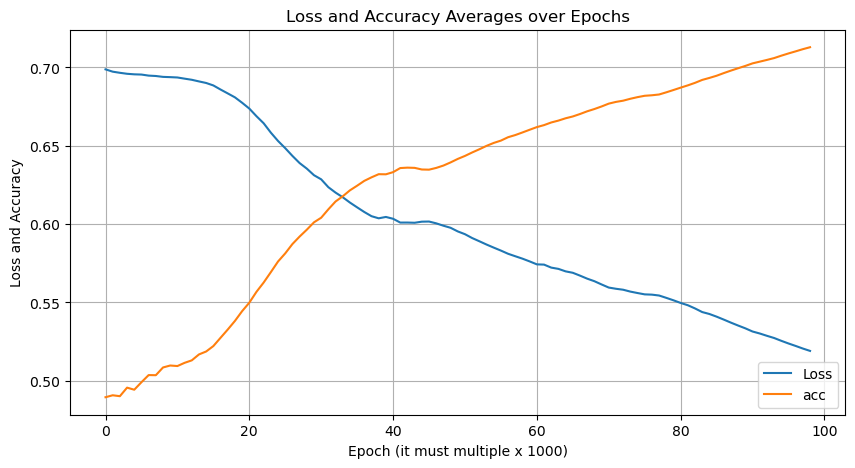

Epoch 99000/100000, Loss: 0.5191, acc : 0.7128917889718286


In [9]:
plot_every = 1000
num_epochs = 100000

losses = []
loss_average_list = []
acc_list = []
acc_list_average = []
for epoch in range(num_epochs):
    x, target, sequence = generate_sequence(palindrome=False)

    optimizer.zero_grad() 
    output, _ = model(x) 

    output = output[-1:] 
    target = target.long()

    loss = nn.CrossEntropyLoss()(output, target)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    acc = accuracy(output, target)
    acc_list.append(acc)
    if epoch % plot_every == 0 and epoch > 0:
        acc_average = np.mean(acc_list)
        loss_average = np.mean(losses)
        loss_average_list.append(loss_average)
        acc_list_average.append(acc_average)
        plot_all(loss_average_list, acc_list_average)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss_average:.4f}, acc : {acc_average}")

In [ ]:
torch.save(model.state_dict(), 'RNN_model_state_dict.pt')
torch.save(model, 'RNN_model.pt')

In [10]:
from collections import defaultdict

length_total = defaultdict(int)
length_correct = defaultdict(int)

with torch.no_grad():
    for i in range(100000):
        if i % 5000 == 0:
            print(f"{i}번 test 진행")
        if i == (100000-1):
            print(f"{i}번 test 진행")
        x, target, sequence = generate_sequence()

        output, _ = model(x)
        output = output[-1:]

        length_total[len(sequence)] += 1
        if torch.argmax(output.squeeze()) == target.item():
            length_correct[len(sequence)] += 1

0번 test 진행
5000번 test 진행
10000번 test 진행
15000번 test 진행
20000번 test 진행
25000번 test 진행
30000번 test 진행
35000번 test 진행
40000번 test 진행
45000번 test 진행
50000번 test 진행
55000번 test 진행
60000번 test 진행
65000번 test 진행
70000번 test 진행
75000번 test 진행
80000번 test 진행
85000번 test 진행
90000번 test 진행
95000번 test 진행
99999번 test 진행


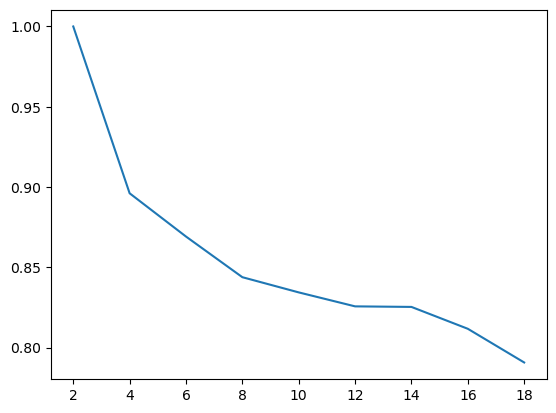

In [12]:
fig, ax = plt.subplots()
x, y = [], []
for i in range(2, 20, 2):
    x.append(i)
    y.append(length_correct[i] / length_total[i])
ax.plot(x, y);